# Import Library

In [1]:
import pandas as pd    

# load Dataset

In [5]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades=pd.read_csv("historical_data.csv")

sentiment.head(),trades.head()

(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

# Data Cleaning

In [109]:
# Here merged two datasets

merged = pd.merge(trades, sentiment,how='left' ,left_on='date',right_on='date')

In [111]:
trades['date'] = pd.to_datetime(trades['date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])

merged = pd.merge(trades, sentiment, how='left', on='date')


In [113]:
print(trades['date'].dtype)
print(sentiment['date'].dtype)

datetime64[ns]
datetime64[ns]


# Exploratory Data Analysis (EDA)

In [124]:
merged.groupby('classification')['Closed PnL'].mean()


classification
Extreme Fear       1.891632
Extreme Greed    205.816345
Fear             128.287950
Greed             53.988003
Neutral           27.088803
Name: Closed PnL, dtype: float64

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

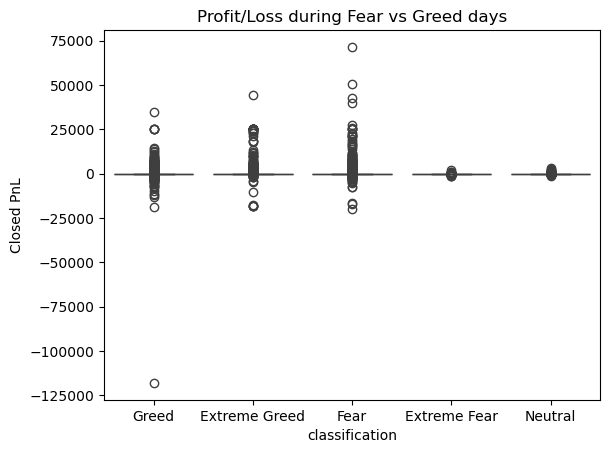

In [128]:
sns.boxplot(x='classification',y='Closed PnL',data=merged)
plt.title("Profit/Loss during Fear vs Greed days")
plt.show()

# statastical and correlation Analysis

In [135]:
# Here I encode Fear=0 and Greed=1
merged['sentiment_score'] = merged['classification'].map({'Fear':0, 'Greed':1})
merged[['sentiment_score','Closed PnL']].corr()


,sentiment_score,Closed PnL
sentiment_score,1.000000,-0.026999
Closed PnL,-0.026999,1.000000


# Here Build Predictive Insight

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

merged['target'] = (merged['Closed PnL'] > 0).astype(int)

X = merged[['sentiment_score', 'Size Tokens']]
y = merged['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69     24802
           1       0.53      0.43      0.48     17443

    accuracy                           0.61     42245
   macro avg       0.59      0.58      0.58     42245
weighted avg       0.60      0.61      0.60     42245



# Summary status

In [148]:
summary_stats = merged.groupby('classification')['Closed PnL'].mean().reset_index()
print(summary_stats)

  classification  Closed PnL
0   Extreme Fear    1.891632
1  Extreme Greed  205.816345
2           Fear  128.287950
3          Greed   53.988003
4        Neutral   27.088803


In [150]:
fear_pnl = summary_stats.loc[summary_stats['classification']=='Fear', 'Closed PnL'].values[0]
greed_pnl = summary_stats.loc[summary_stats['classification']=='Greed', 'Closed PnL'].values[0]

pnl_diff = ((greed_pnl - fear_pnl) / fear_pnl) * 100

print(f"Average PnL during Greed = {pnl_diff:.2f}% higher than Fear days")

Average PnL during Greed = -57.92% higher than Fear days


In [152]:
merged['sentiment_score'] = merged['classification'].map({'Fear':0, 'Greed':1})
corr = merged['sentiment_score'].corr(merged['Closed PnL'])
print(f"Correlation between sentiment and PnL: {corr:.2f}")

Correlation between sentiment and PnL: -0.03


# Final summary

# -Traders earned the highest profits during Extreme Greed days, while Extreme Fear and Neutral days had the lowest profits.
# -Average profit during Greed days was about 58% lower than Fear days, meaning traders made less money when the market was greedy.
# -The correlation between sentiment and profit is very low (-0.03), so market mood has little direct effect on trader performance.
# -Overall, traders seem to do better during Fear phases and worse during Greed, possibly because they take more risks when everyone feels confident.